In [2]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import scipy
from sklearn.preprocessing import normalize
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import csv 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_regression


In [3]:
root_path = "C:/Users/darsh/Downloads/Srujan/16.MicrosoftMalware-20220713T122459Z-001/MicrosoftMalware/"

In [4]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [9]:
# list byteFiles directory
byte_files = os.listdir('byteFiles')

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_tokens="00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,\
2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,\
59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,\
87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,\
b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,\
e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

bigram_tokens=bigram_tokens.split(",")

# Between 00 and FF there are 256 unique values, so if we take each pair of Hexadecimal Values as one word, 
# we are dealing with 256 unique values. 
# Hence below Function will extract all the possible combinations of bigrams_counts
def calculate_bigram(bigram_tokens):
    sentence=""
    vocabulary_list_for_byte_bigrams=[]
    for i in tqdm(range(len(bigram_tokens))):
        for j in range(len(bigram_tokens)):
            bigram=bigram_tokens[i]+" "+bigram_tokens[j]
            sentence=sentence+bigram+","
            vocabulary_list_for_byte_bigrams.append(bigram)
    return vocabulary_list_for_byte_bigrams


In [6]:
%%time
vocabulary_list_for_byte_bigrams = calculate_bigram(bigram_tokens)

100%|███████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 712.11it/s]

CPU times: total: 141 ms
Wall time: 366 ms


In [10]:
if not os.path.isdir(root_path + "featurization"):
    os.makedirs(root_path + "featurization")

if not os.path.isdir(root_path + "featurization/featurization_final"):
    os.mkdir(root_path + "featurization/featurization_final")

In [11]:
%%time
#https://github.com/rohan-paul/Microsoft_Malware_Prediction_BIG_2015/blob/main/Microsoft_Malware_BIG_2015_Kaggle.ipynb
import scipy
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(),
                             lowercase=False, 
                             ngram_range=(2,2),
                             vocabulary=vocabulary_list_for_byte_bigrams) 

# For Explanations on "tokenizer=lambda x: x.split()"
# Refer - https://stackoverflow.com/a/37884104/1902852
# Without this "??" was not getting vectorized properly

file_list_byte_files=os.listdir(root_path + 'byteFiles')

features=["ID"]+vectorizer.get_feature_names()

byte_file_bigram_df=pd.DataFrame(columns=features)

# Creating "featurization/byte_files_bigram_df.csv" and writng to it the full bi-gram data frame
with open(root_path + "featurization/byte_files_bigram_df.csv", mode='w',) as byte_file_bigram_df:
    byte_file_bigram_df.write(','.join(map(str, features)))
    byte_file_bigram_df.write('\n')
    for _, file in tqdm(enumerate(file_list_byte_files)):
        file_id=file.split(".")[0] #ID of each file
        file = open(root_path + 'byteFiles/' + file)
        corpus_byte_codes=[file.read().replace('\n', ' ').lower()] # corpus_byte_codes holds all the byte codes for a given file
        bigrams_counts = vectorizer.transform(corpus_byte_codes) # Returning a sparse vector containing all the bigram counts from the corpus_byte_codes
        
        # Update each row of our dataframe with the bigram counts of the respective file
        row = scipy.sparse.csr_matrix(bigrams_counts).toarray() 
        
        # Write a single row in the CSV file
        byte_file_bigram_df.write(','.join(map(str, [file_id]+list(row[0]))))
        
        byte_file_bigram_df.write('\n')
        
        file.close()

10868it [3:00:43,  1.00it/s]

CPU times: total: 2h 22min 8s
Wall time: 3h 44s


In [7]:
%%time

# Load the byte_files_bigram_df.csv file which is NOT normalized dataset for the byte file's bigrams
# that we created in the previous cell
X_byte_bigram_all_df = pd.read_csv(root_path + "featurization/byte_files_bigram_df.csv")

X_byte_bigram_all_df.head(2)

CPU times: total: 11min 15s
Wall time: 14min 14s


ID   00 00  00 01  00 02  00 03  00 04  00 05  00 06  \
0  01azqd4InC7m9JpocGv5  274425   1269   1029   1469   1227   1144   1437   
1  01IsoiSMh5gxyDYTl4CB   21075    752     73     48    175     12     10   

   00 07  00 08  ...  ?? f7  ?? f8  ?? f9  ?? fa  ?? fb  ?? fc  ?? fd  ?? fe  \
0   1263   1174  ...      0      0      0      0      0      0      0      0   
1     11     42  ...      0      0      0      0      0      0      0      0   

   ?? ff  ?? ??  
0      0   1819  
1      0   8580  

[2 rows x 66050 columns]

In [8]:
unigram_byte_files_with_size = pd.read_csv('result_with_size.csv').drop('Unnamed: 0',axis=1)[['ID','Class']]

In [9]:
bigrams_byte_files = pd.merge(X_byte_bigram_all_df,unigram_byte_files_with_size, on =['ID'],how='left')

In [10]:
bigrams_byte_files.to_csv('bigrams_byte_files_with_class.csv',index=False)

In [11]:
%%time
bigrams_byte_files = pd.read_csv('bigrams_byte_files_with_class.csv')

CPU times: total: 12min 37s
Wall time: 15min 34s


In [12]:
%%time
labels = bigrams_byte_files['Class']
bigrams_byte_files_ = bigrams_byte_files.drop(['ID','Class'],axis=1)

CPU times: total: 1.44 s
Wall time: 1.6 s


In [13]:
%%time
num_of_feats = 2000
# Create and fit selector
selector = SelectKBest(chi2, k=num_of_feats)
a = selector.fit(bigrams_byte_files_, labels)
scores = pd.DataFrame(a.scores_,columns=['scores'])
columns = pd.DataFrame(bigrams_byte_files_.columns,columns=['features'])
b = pd.concat([columns,scores],axis=1)
b = b.nlargest(num_of_feats,'scores')
features_df_new = bigrams_byte_files_[b.features.values.tolist()]

CPU times: total: 24 s
Wall time: 25.3 s


In [14]:
%%time
top_2000_imp_byte_bigram_df = pd.concat([bigrams_byte_files['ID'],features_df_new],axis=1)
unigram_byte_files_with_size = pd.read_csv('result_with_size.csv').drop('Unnamed: 0',axis=1)[['ID','Class']]
top_2000_imp_byte_bigram_df = pd.merge(top_2000_imp_byte_bigram_df,unigram_byte_files_with_size, on =['ID'],how='left')

CPU times: total: 297 ms
Wall time: 438 ms


In [15]:
top_2000_imp_byte_bigram_df.head()

ID  ?? ??  cc cc   00 00  ff ff  00 ff  ff 00  02 02  \
0  01azqd4InC7m9JpocGv5   1819     99  274425    876   1906   1502     74   
1  01IsoiSMh5gxyDYTl4CB   8580    732   21075   4861   1036   2202     23   
2  01jsnpXSAlgw6aPeDxrU    459      7   16798   2358   3076   2960      4   
3  01kcPWA9K2BOxQeS5Rju  13932     22   10417   1363    694    698      3   
4  01SuzwMJEIXsK7A8dQbl   9000     31   16271     76     64     24      0   

   10 10  f0 f0  ...  11 5e  f0 11  84 11  2c 02  11 4d  9d 02  46 13  58 58  \
0     98     84  ...      7      4      4     10      8      3      6     86   
1    195     21  ...      0      0      0      1      0      2      1      1   
2      5      3  ...      3      3      3      2      5      3      5      5   
3     10     11  ...      0      2      0      5      0      1      0     12   
4      2      1  ...      1      0      2      2      2      1      1      1   

   e6 f7  Class  
0      7      9  
1      1      2  
2      2      9  
3      1      1  
4      0      8  

[5 rows x 2002 columns]

In [16]:
%%time
top_2000_imp_byte_bigram_df.to_csv("featurization/featurization_final/top_2000_imp_byte_bigram_df.csv",index=None)

CPU times: total: 3.22 s
Wall time: 3.55 s


In [104]:
%%time
top_2000_imp_byte_bigram_df = pd.read_csv("featurization/featurization_final/top_2000_imp_byte_bigram_df.csv")

CPU times: total: 1.66 s
Wall time: 1.72 s


In [105]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

In [106]:
%%time
x = normalize(top_2000_imp_byte_bigram_df.drop(['ID','Class'],axis=1))
y = top_2000_imp_byte_bigram_df['Class']

CPU times: total: 57.7 s
Wall time: 59.5 s


In [111]:
%%time
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.20,random_state=42)
X_train_, X_cv, y_train_, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20,random_state=42)

CPU times: total: 188 ms
Wall time: 204 ms


#  Random Forest Model on bi-grams of Byte Files

log_loss for c =  10 is 0.07732843962346451
log_loss for c =  50 is 0.07012673917213798
log_loss for c =  100 is 0.0692983490159106
log_loss for c =  500 is 0.06996472343348797
log_loss for c =  1000 is 0.0697666801576343
log_loss for c =  2000 is 0.06959303639453963
log_loss for c =  3000 is 0.06945100191268584


<IPython.core.display.Javascript object>


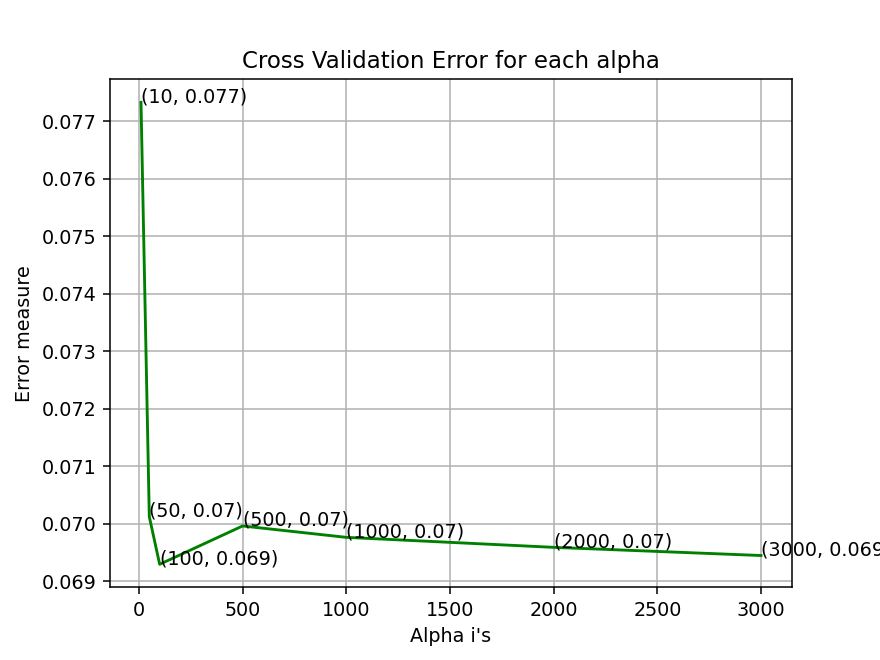

In [112]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_,y_train_)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_, y_train_)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



In [113]:
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_,y_train_)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_, y_train_)



CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_jobs=-1,
                                                             random_state=42))

For values of best alpha =  100 The train log loss is: 0.018128341081802463
For values of best alpha =  100 The cross validation log loss is: 0.0692983490159106
For values of best alpha =  100 The test log loss is: 0.05133416331735907
Number of misclassified points  0.9659613615455382
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


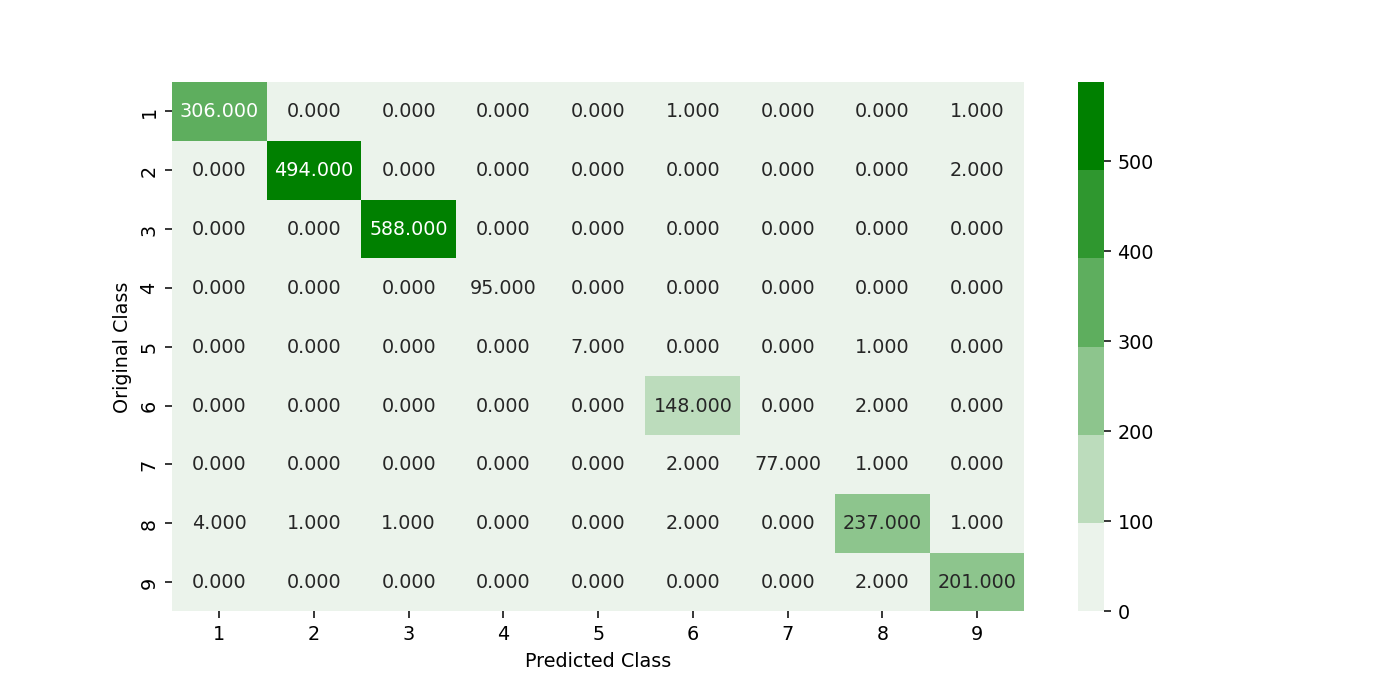

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


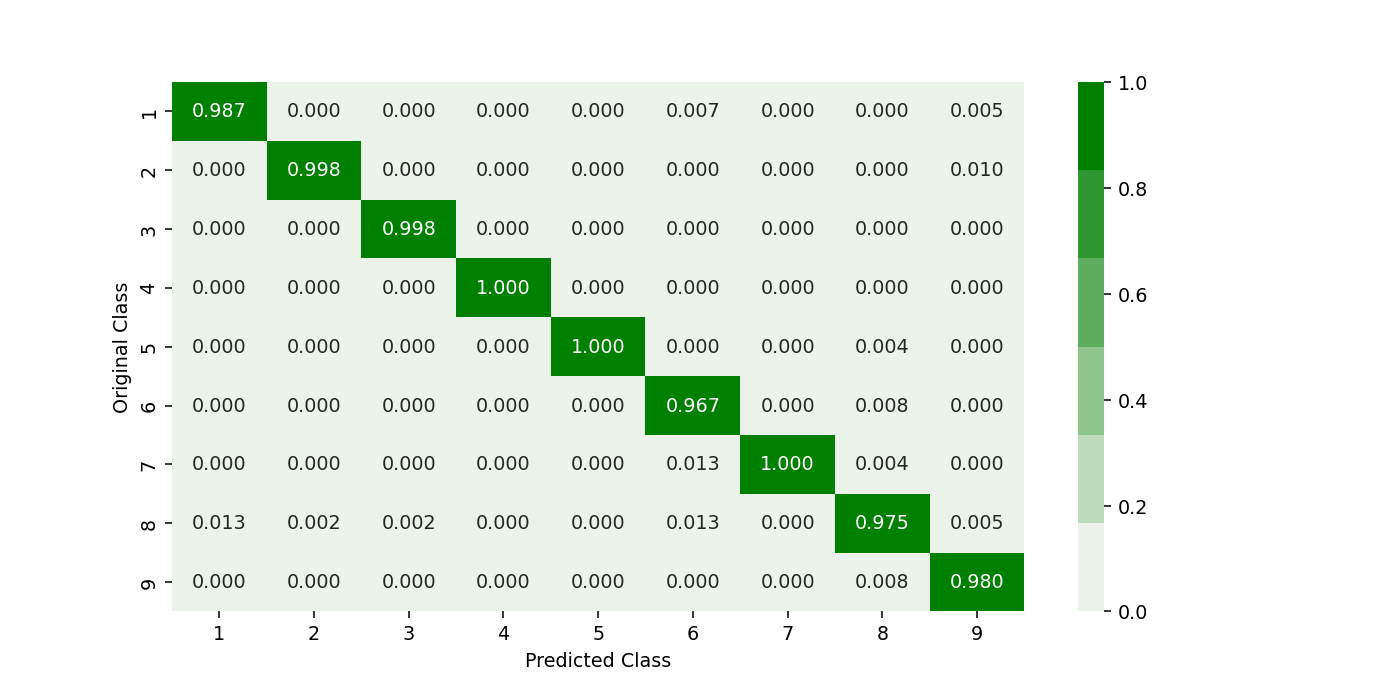

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


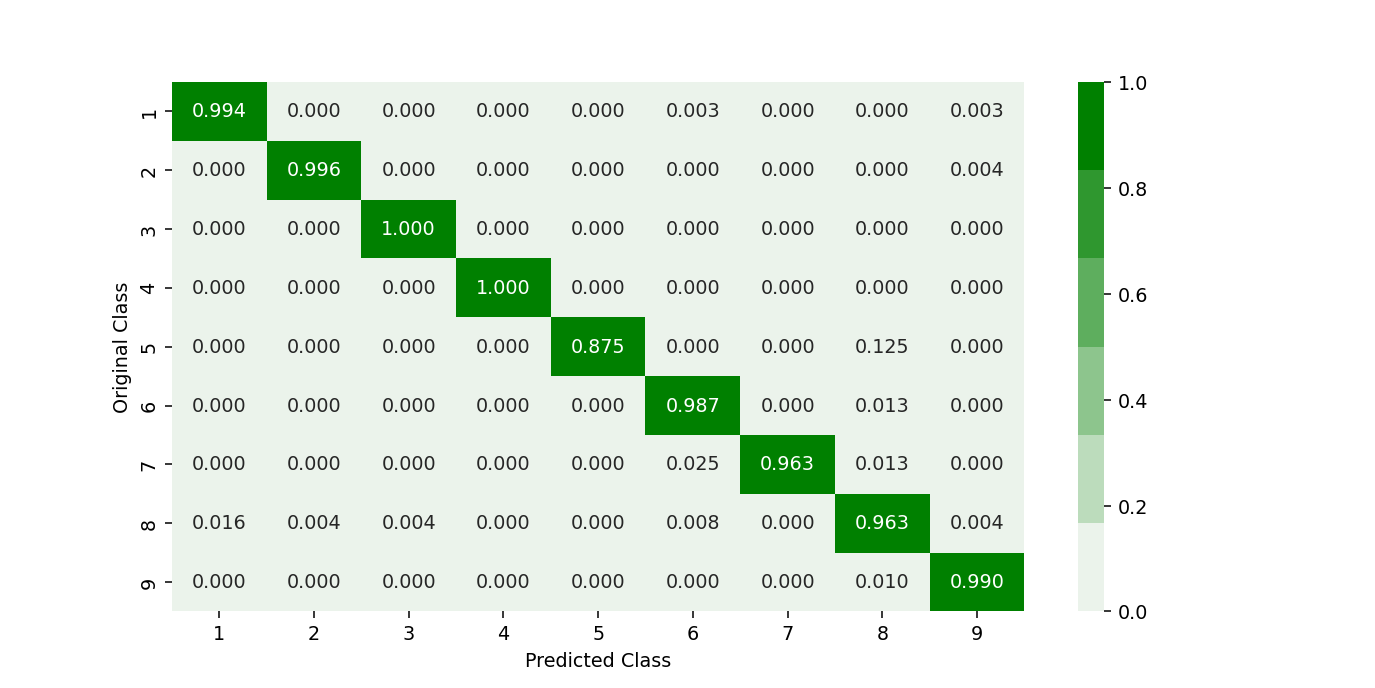

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [114]:
predict_y = sig_clf.predict_proba(X_train_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

# XGBoost

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#bigram_byte_df_final = pd.read_csv(root_path + "featurization/top_2K_feats_byte_files_bigram_df.csv").drop('Unnamed: 0',axis=1)


x = normalize(top_2000_imp_byte_bigram_df.drop(['ID','Class'],axis=1))
y = top_2000_imp_byte_bigram_df['Class']

#x = normalize(bigram_byte_df_final.drop(['ID','Class'],axis=1),axis=0)
#y = bigram_byte_df_final['Class']
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_enc,stratify=y_enc,test_size=0.20)
X_train_, X_cv, y_train_, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

log_loss for c =  10 is 0.06568657055746402
log_loss for c =  50 is 0.059026350410550016
log_loss for c =  100 is 0.05798046616471082
log_loss for c =  500 is 0.05716026247856087
log_loss for c =  1000 is 0.05716206742143223
log_loss for c =  2000 is 0.057162646292404896


<IPython.core.display.Javascript object>


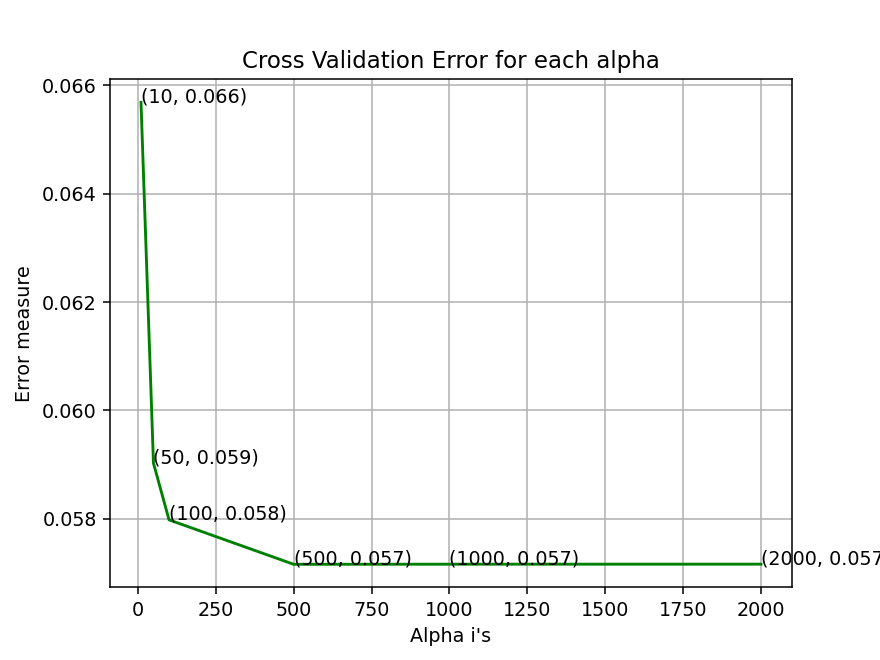

For values of best alpha =  500 The train log loss is: 0.015733513741135633
For values of best alpha =  500 The cross validation log loss is: 0.05716026247856087
For values of best alpha =  500 The test log loss is: 0.04082778173909302
Number of misclassified points  0.78196872125115
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


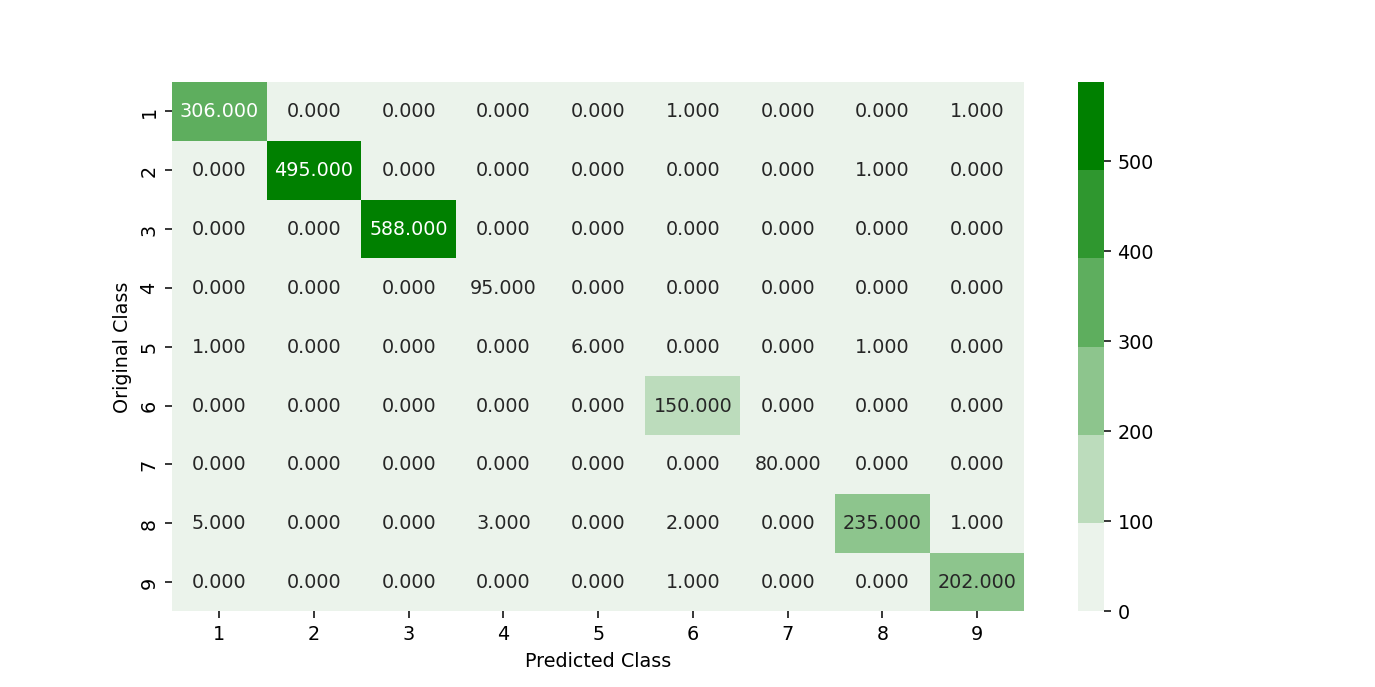

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


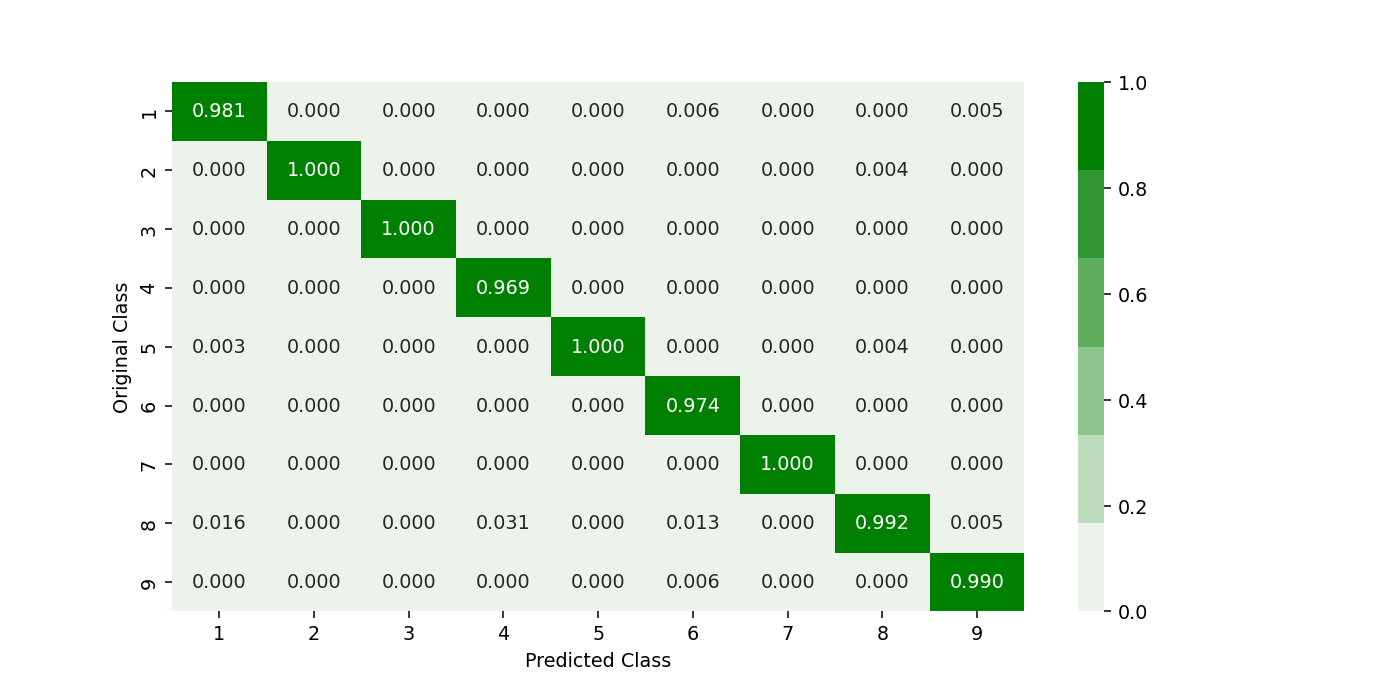

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


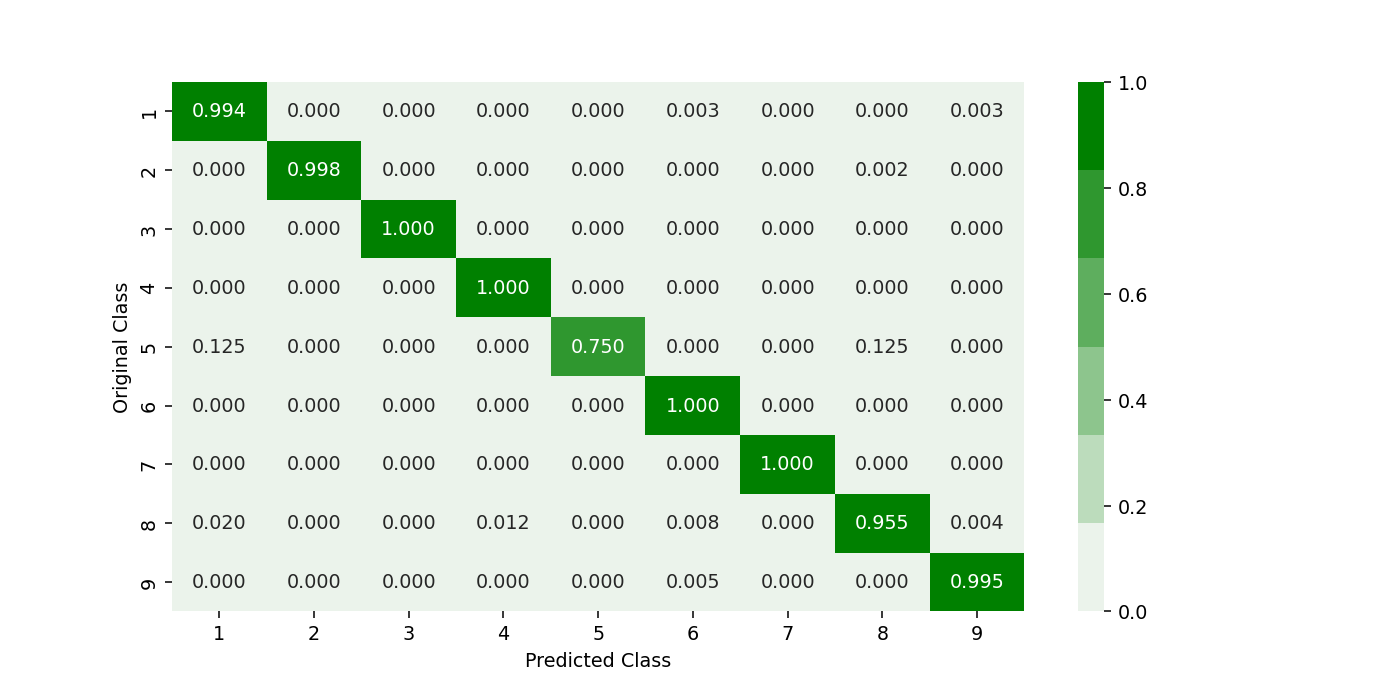

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [24]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_,y_train_)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_, y_train_)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_,y_train_)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_, y_train_)
    
predict_y = sig_clf.predict_proba(X_train_)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [25]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train_,y_train_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'subsample': [0.1, 0.3, 0.5, 1]},
                   verbose=10)

In [26]:
print(random_cfl1.best_params_)

{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [27]:
x_cfl=XGBClassifier(random_cfl1.best_params_,nthread=-1)
x_cfl.fit(X_train_,y_train_,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_, y_train_)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None,
                                                    feature_types=None,
                                                    gamma=None, gpu_id=None,
                                                    grow_policy=None,
                                                    importance_type=None,
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_bin=None,
                                                    max_cat_threshold=None,
                                                    max_cat_to_onehot=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    max_leaves=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    n_estimators=100,
                                                    n_jobs=None, nthread=-1,
                                                    num_parallel_tree=None,
                                                    objective='multi:softprob', ...))

For values of best alpha =  500 The train log loss is: 0.01607241888209106
For values of best alpha =  500 The cross validation log loss is: 0.05798046616471082
For values of best alpha =  500 The test log loss is: 0.042548217106847336
Number of misclassified points  0.78196872125115
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


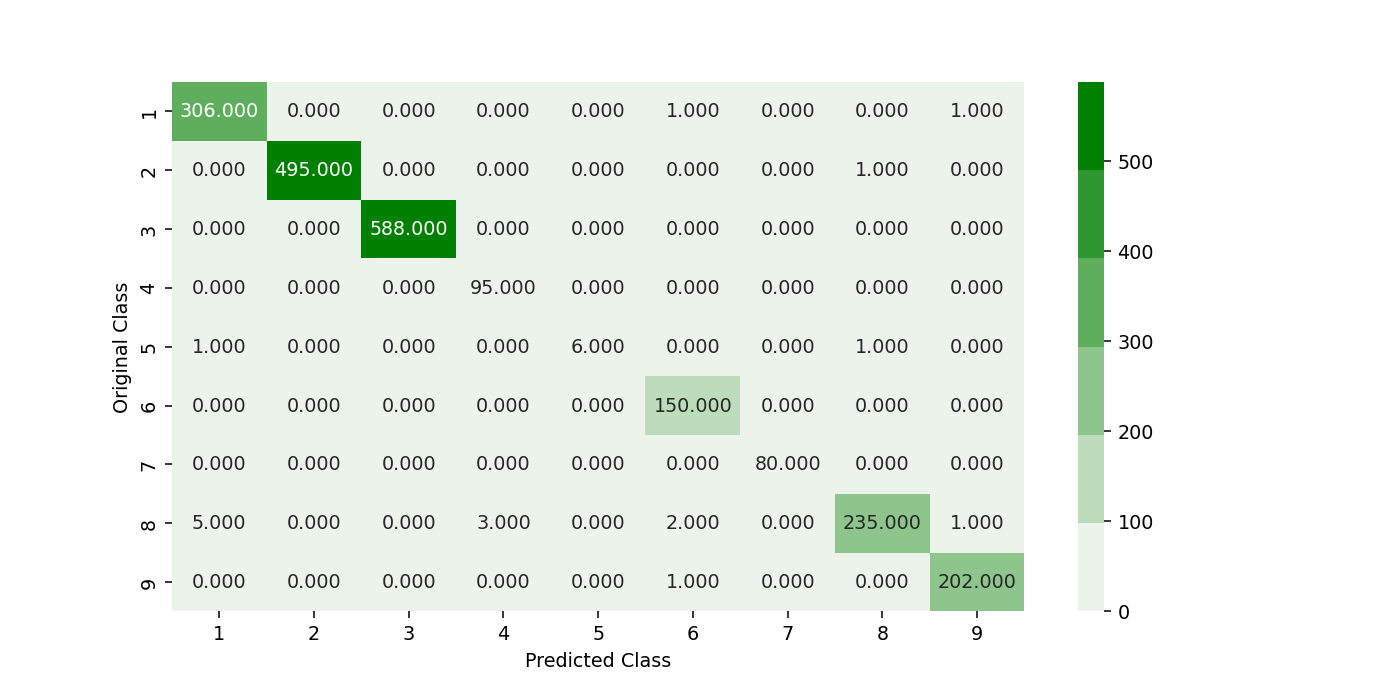

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


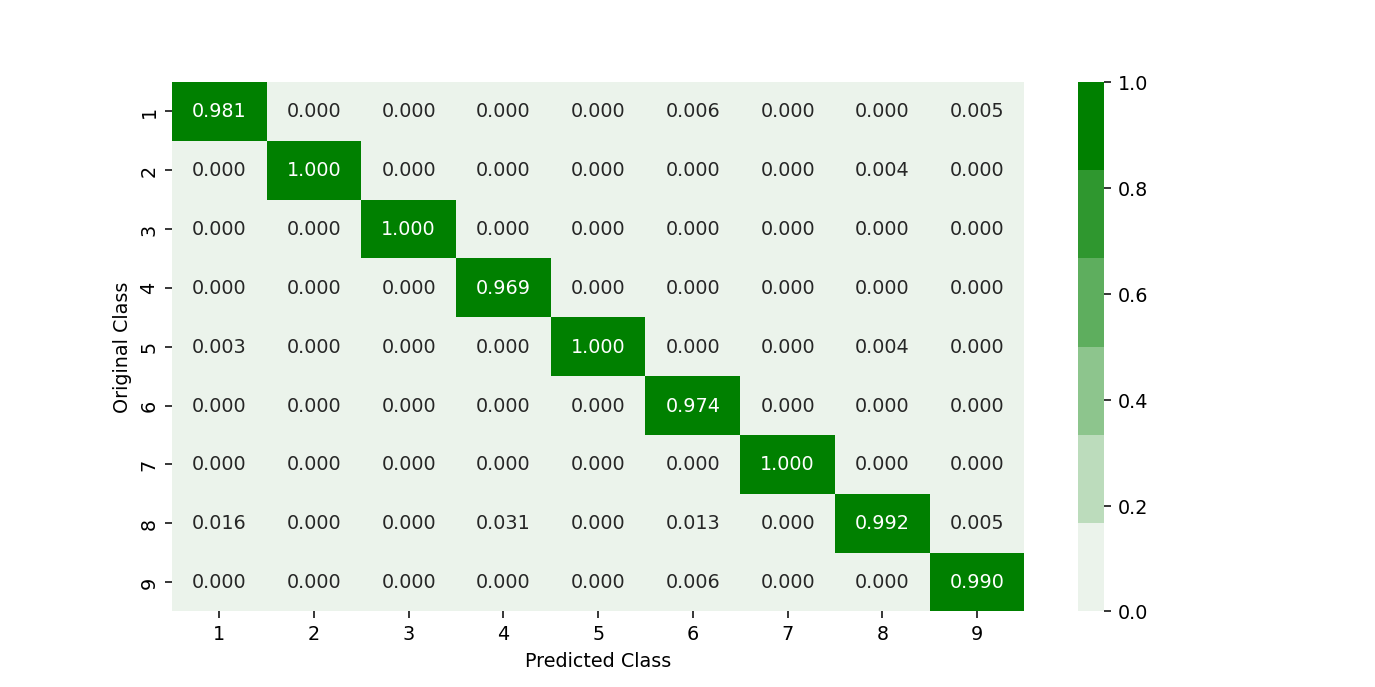

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


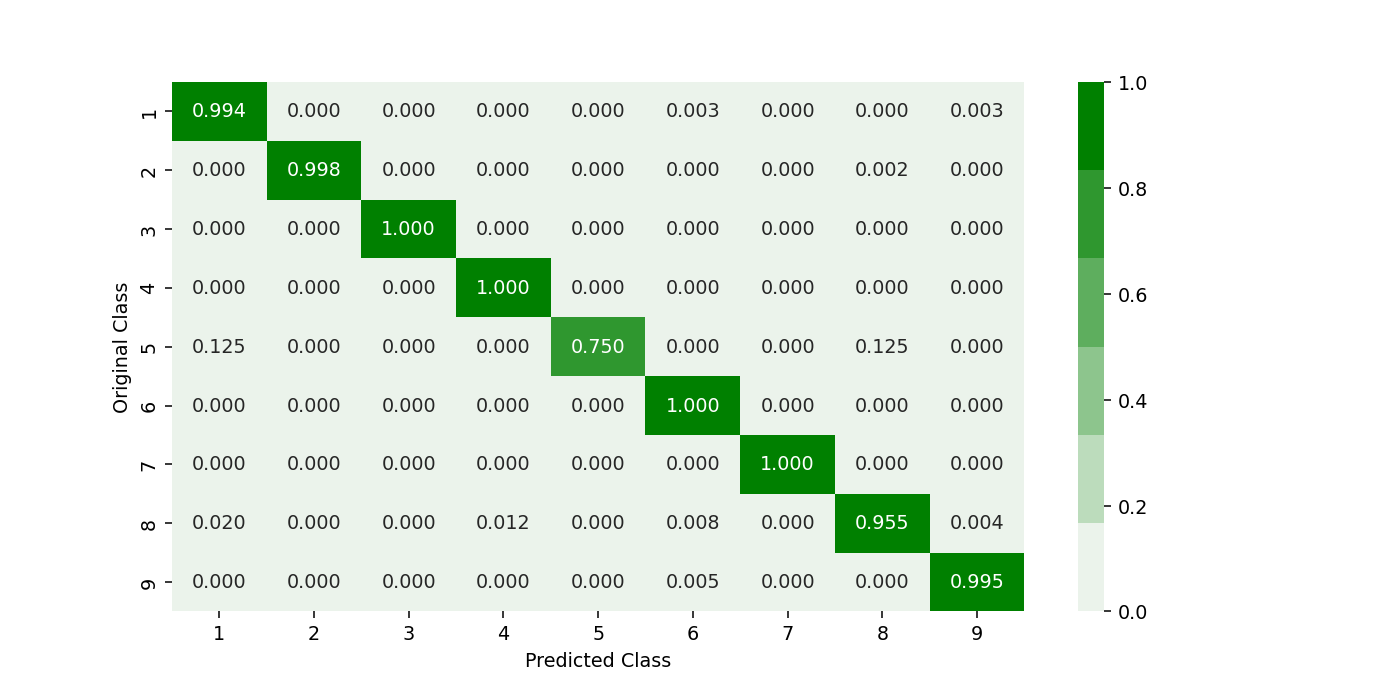

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [28]:
predict_y = sig_clf.predict_proba(X_train_)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plt.close()
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [ ]:
For values of best alpha =  100 The train log loss is: 0.018128341081802463
For values of best alpha =  100 The cross validation log loss is: 0.0692983490159106
For values of best alpha =  100 The test log loss is: 0.05133416331735907
Number of misclassified points  0.9659613615455382

In [115]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names  = ['Model', 'Best HyperParameter', 'Train Log Loss', 'CV Log Loss', 'Test Log Loss', 'Number of Misclassified Points']

#table.add_row(['Random Forest',])
table.add_row(['Random_Forest_Classifier', 100, 0.018128,  0.0692, 0.0512, 0.9659])
table.add_row(['Xgboost Classifier', 500,  0.0160, 0.0579, 0.0425,  0.7819])

print(table)

+--------------------------+---------------------+----------------+-------------+---------------+--------------------------------+
|          Model           | Best HyperParameter | Train Log Loss | CV Log Loss | Test Log Loss | Number of Misclassified Points |
+--------------------------+---------------------+----------------+-------------+---------------+--------------------------------+
| Random_Forest_Classifier |         100         |    0.018128    |    0.0692   |     0.0512    |             0.9659             |
|    Xgboost Classifier    |         500         |     0.016      |    0.0579   |     0.0425    |             0.7819             |
+--------------------------+---------------------+----------------+-------------+---------------+--------------------------------+


# ASM files

In [ ]:
dfasm=pd.read_csv(root_path + "/asmoutputfile.csv")

Y = pd.read_csv(root_path + "trainLabels.csv")
Y.columns = ['ID', 'Class'] 

unigram_asm = pd.merge(dfasm, Y, on='ID', how='left')

cols = ['HEADER:', '.text:', '.Pav:', '.idata:', '.data:', '.bss:',
        '.rdata:', '.edata:', '.rsrc:', '.tls:', '.reloc:', '.BSS:', '.CODE',
        'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc',
        'dec', 'add', 'imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror',
        'rol', 'jnb', 'jz', 'rtn', 'lea', 'movzx', '.dll', 'std::', ':dword',
        'edx', 'esi', 'eax', 'ebx', 'ecx', 'edi', 'ebp', 'esp', 'eip',]

final_unigram_asm = pd.DataFrame((unigram_asm[cols]),columns=cols)

#final_unigram_asm.head()

final_unigram_asm = pd.concat([unigram_asm[["ID"]], final_unigram_asm,], axis=1)

In [ ]:
unigram_asm_with_size = pd.read_csv('asm_with_size.csv').drop(['Unnamed: 0'],axis=1)

In [ ]:
unigram_asm_with_size_final = final_unigram_asm.merge(unigram_asm_with_size,how='left',on='ID')

In [ ]:
%%time
import time,array
import imageio,cv2
import numpy as np
import os
import codecs
import imageio
import array
from datetime import datetime as dt

files = os.listdir(root_path + '/asmFiles')
for file in tqdm(files):
    if file.endswith('.asm'):
        f = codecs.open(root_path + '/asmFiles/'+file,'rb')
        ln = os.path.getsize(root_path + '/asmFiles/'+file)
        width = int(ln**0.5)
        rem = (ln%width)
        a = array.array('B')
        #a.frombytes(f.read())
        a.fromfile(f,ln-rem)
        f.close
        g = np.reshape(a[:width*width],(width,width))
        g=np.uint8(g)
        #print(g.shape)
        imageio.imwrite("C:/Users/darsh/Downloads/Srujan/16.MicrosoftMalware-20220713T122459Z-001/MicrosoftMalware/asm_images_folder_2/"+file.split('.')[0]+'.png',g)


5OsZTkXgflhr4VAFmxE7.png


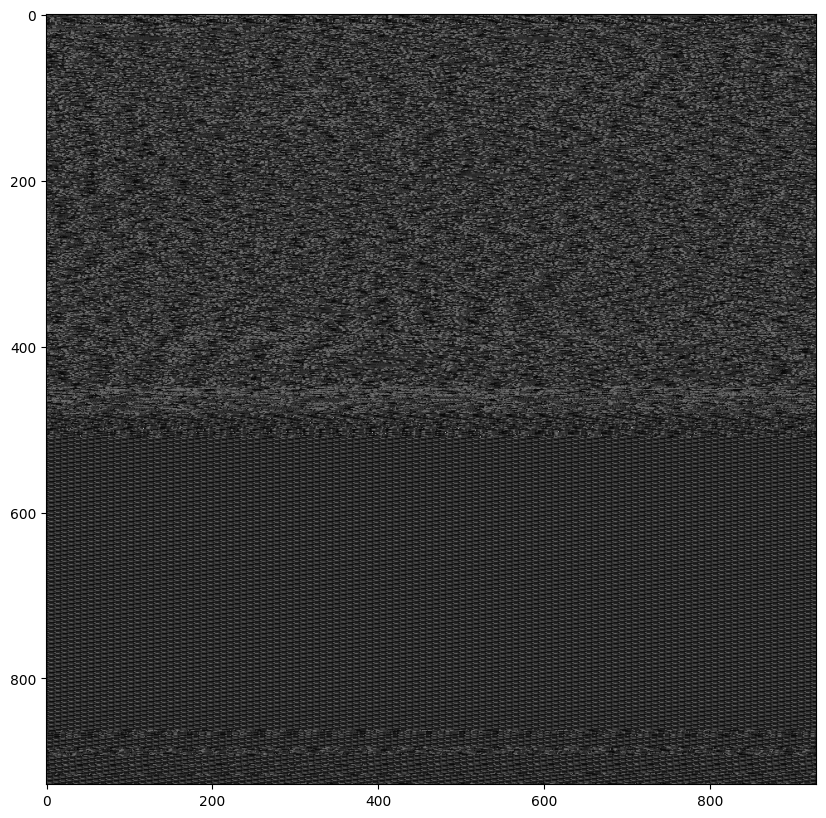

In [61]:
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline
        
# Hide grid lines
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
img_path = "C:/Users/darsh/Downloads/Srujan/16.MicrosoftMalware-20220713T122459Z-001/MicrosoftMalware/asm_images_folder_2/"
img = random.choice(os.listdir(img_path))
print(img)
im=cv2.imread(img_path+img)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:

img_path = root_path+'asm_images_folder_2/'
c=0
with open(root_path+"featurization/asm_image_values.csv",mode='w', newline='') as asm_image_values:
    columns = ['asm_pixel_value_{}'.format(i) for i in range(800)]
    columns.insert(0,'ID')
    writer = csv.writer(asm_image_values)
    writer.writerow(columns)
    #writer.writerow('\n')
    for image_file in tqdm(os.listdir(img_path)):
        img = imageio.imread(img_path+image_file) #np.array(img.getdata())[:800]
        data = list(img.flatten()[:800])
        data.insert(0,image_file.split(".")[0])
        writer.writerow(data)
        

In [ ]:
%%time
#https://github.com/rohan-paul/Microsoft_Malware_Prediction_BIG_2015/blob/main/Microsoft_Malware_BIG_2015_Kaggle.ipynb
opcodes_for_bigram = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']


dict_asm_opcodes = dict(zip(opcodes_for_bigram, [1 for i in range(len(opcodes_for_bigram))]))
if not os.path.isdir(root_path + "opcodes_asm_files"):
    os.mkdir(root_path + 'opcodes_asm_files')
def calculate_sequence_of_opcodes():
    asm_file_names=os.listdir(root_path + 'asmFiles')
    for this_asm_file in tqdm(asm_file_names):
        each_asm_opcode_file = open(root_path + "opcodes_asm_files/{}_opcode_asm_bi_grams.txt".format(this_asm_file.split('.')[0]), "w+")
        sequence_of_opcodes = ""
        with codecs.open(root_path + 'asmFiles/' + this_asm_file, encoding='cp1252', errors ='replace') as asm_file:
            for lines in asm_file:
                line = lines.rstrip().split()            
                for word in line:
                    if dict_asm_opcodes.get(word)==1:
                        sequence_of_opcodes += word + ' '
        each_asm_opcode_file.write(sequence_of_opcodes + "\n")
        each_asm_opcode_file.close()
    
calculate_sequence_of_opcodes()

# bigrams of opcodes for asm files

In [31]:
opcodes_for_bigram = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
bigram_feats_opcode = (calculate_bigram(opcodes_for_bigram))
print('bigram_feats_opcode without ID',len(bigram_feats_opcode))
bigram_feats_opcode.insert(0,'ID')
print('bigram_feats_opcode with ID',len(bigram_feats_opcode))

p1 = "C:/Users/darsh/Downloads/Srujan/16.MicrosoftMalware-20220713T122459Z-001/MicrosoftMalware/opcodes_asm_files/"

opcodes_asm_all_files = os.listdir('opcodes_asm_files/')

with open('featurization/opcodes_asm_bigram_df.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    #(bigram_feats_opcode).insert(0,'ID')
    writer.writerow(bigram_feats_opcode)
    bigram_feats_opcode.remove('ID')
    vectorizer_asm_opcode = CountVectorizer(ngram_range=(2,2),
                                            vocabulary=bigram_feats_opcode,
                                            tokenizer=lambda x: x.split(),
                                            lowercase=False,
                                           )
    for file in tqdm(opcodes_asm_all_files):
        file_path = open(p1+file)
        file_data = file_path.read()
        #print(file_path.read())
        file_vectorizer = vectorizer_asm_opcode.transform([file_data])
        file_data_list = list(scipy.sparse.csr_matrix(file_vectorizer).toarray()[0])
        file_data_list.insert(0,file.split('.')[0].split('_')[0])
        writer.writerow(file_data_list)
        #break
        

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 12988.55it/s]


bigram_feats_opcode without ID 676
bigram_feats_opcode with ID 677


100%|████████████████████████████████████████████████████████████████████████████| 10868/10868 [02:09<00:00, 84.20it/s]


In [32]:
%%time
opcodes_asm_bigram_df = pd.read_csv('featurization/opcodes_asm_bigram_df.csv')
asmwithsize = pd.read_csv('asm_with_size.csv').drop('Unnamed: 0',axis=1)
opcodes_asm_bigram_df_final = pd.merge(opcodes_asm_bigram_df,asmwithsize,on=['ID'],how='left')

num_of_feats = 500
labels = opcodes_asm_bigram_df_final['Class']
df_final_ = opcodes_asm_bigram_df_final.drop(['ID','Class'],axis=1)
selector = SelectKBest(chi2, k=num_of_feats)
a = selector.fit(df_final_, labels)
scores = pd.DataFrame(a.scores_,columns=['scores'])
columns = pd.DataFrame(df_final_.columns,columns=['features'])
b = pd.concat([columns,scores],axis=1)
b = b.nlargest(num_of_feats,'scores')
features_df_new = df_final_[b.features.values.tolist()]

#
top_500_asm_opcodes_bigram_df = pd.concat([opcodes_asm_bigram_df_final['ID'],features_df_new,opcodes_asm_bigram_df_final['Class']],axis=1)
top_500_asm_opcodes_bigram_df.to_csv('featurization/featurization_final/top_500_asm_opcodes_bigram_df.csv',index=None)

CPU times: total: 1.45 s
Wall time: 1.53 s


In [33]:
top_500_asm_opcodes_bigram_df = pd.read_csv('featurization/featurization_final/top_500_asm_opcodes_bigram_df.csv')
top_500_asm_opcodes_bigram_df.head()

ID  mov mov  push push  push mov  push call  imul mov  \
0  01azqd4InC7m9JpocGv5     1747       1594       577        678        50   
1  01IsoiSMh5gxyDYTl4CB     1157        114       160        157        19   
2  01jsnpXSAlgw6aPeDxrU        0        181        26        118         0   
3  01kcPWA9K2BOxQeS5Rju       25         26        10         27         0   
4  01SuzwMJEIXsK7A8dQbl     1212         27       221        121         0   

   mov imul  mov push  call mov  mov call  ...  jnb rol  retn shl  sub jnb  \
0        44       843       969       497  ...        0         0        0   
1        23       240        98       121  ...        0         0        0   
2         0         0         2         0  ...        0         0        0   
3         0        14        18         6  ...        0         0        0   
4         1       303        98         2  ...        0         0        0   

   jmp ror  call shl  inc imul  shr retn  call shr  nop retf  Class  
0        0         0         0         0         0         0      9  
1        0         0         0         0         0         0      2  
2        0         0         0         0         0         0      9  
3        0         0         0         0         0         0      1  
4        0         0         0         0         0         0      8  

[5 rows x 502 columns]

# Trigrams of asm files

In [34]:
def calculate_trigram(tokens):
    sent = ""
    trigram_result = []
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            for k in range(len(tokens)):
                trigram = tokens[i] + " " + tokens[j] + " " + tokens[k]
                trigram_result.append(trigram)
    return trigram_result

In [35]:
opcodes_for_trigram = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
trigram_feats_opcode = (calculate_trigram(opcodes_for_trigram))
print('trigram_feats_opcode without ID',len(trigram_feats_opcode))
trigram_feats_opcode.insert(0,'ID')
print('trigram_feats_opcode with ID',len(trigram_feats_opcode))

with open('featurization/opcodes_asm_trigram_df.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    #(bigram_feats_opcode).insert(0,'ID')
    writer.writerow(trigram_feats_opcode)
    trigram_feats_opcode.remove('ID')
    vectorizer_asm_opcode = CountVectorizer(ngram_range=(3,3),
                                            vocabulary=trigram_feats_opcode,
                                            tokenizer=lambda x: x.split(),
                                            lowercase=False,
                                           )
    for file in tqdm(opcodes_asm_all_files):
        file_path = open(p1+file)
        file_data = file_path.read()
        #print(file_path.read())
        file_vectorizer = vectorizer_asm_opcode.transform([file_data])
        file_data_list = list(scipy.sparse.csr_matrix(file_vectorizer).toarray()[0])
        file_data_list.insert(0,file.split('.')[0].split('_')[0])
        writer.writerow(file_data_list)
        #break
        

trigram_feats_opcode without ID 17576
trigram_feats_opcode with ID 17577


100%|████████████████████████████████████████████████████████████████████████████| 10868/10868 [02:20<00:00, 77.53it/s]


In [36]:
%%time
opcodes_asm_trigram_df = pd.read_csv('featurization/opcodes_asm_trigram_df.csv')
asmwithsize = pd.read_csv('asm_with_size.csv').drop('Unnamed: 0',axis=1)

opcodes_asm_trigram_df_final = pd.merge(opcodes_asm_trigram_df,asmwithsize,on=['ID'],how='left')



num_of_feats = 800
labels = opcodes_asm_trigram_df_final['Class']
df_final_ = opcodes_asm_trigram_df_final.drop(['ID','Class'],axis=1)
selector = SelectKBest(chi2, k=num_of_feats)
a = selector.fit(df_final_, labels)
scores = pd.DataFrame(a.scores_,columns=['scores'])
columns = pd.DataFrame(df_final_.columns,columns=['features'])
b = pd.concat([columns,scores],axis=1)
b = b.nlargest(num_of_feats,'scores')
features_df_new = df_final_[b.features.values.tolist()]


top_800_asm_opcodes_trigram_df = pd.concat([opcodes_asm_trigram_df_final['ID'],features_df_new,opcodes_asm_trigram_df_final['Class']],axis=1)

top_800_asm_opcodes_trigram_df.to_csv('featurization/featurization_final/top_800_asm_opcodes_trigram_df.csv',index=None)

CPU times: total: 1min 3s
Wall time: 1min 4s


In [66]:
top_800_img_feats.head()

ID  asm_pixel_value_0  asm_pixel_value_1  \
0  01azqd4InC7m9JpocGv5                 72                 69   
1  01IsoiSMh5gxyDYTl4CB                 46                116   
2  01jsnpXSAlgw6aPeDxrU                 72                 69   
3  01kcPWA9K2BOxQeS5Rju                 72                 69   
4  01SuzwMJEIXsK7A8dQbl                 72                 69   

   asm_pixel_value_2  asm_pixel_value_3  asm_pixel_value_4  asm_pixel_value_5  \
0                 65                 68                 69                 82   
1                101                120                116                 58   
2                 65                 68                 69                 82   
3                 65                 68                 69                 82   
4                 65                 68                 69                 82   

   asm_pixel_value_6  asm_pixel_value_7  asm_pixel_value_8  ...  \
0                 58                 48                 48  ...   
1                 48                 48                 52  ...   
2                 58                 48                 48  ...   
3                 58                 49                 48  ...   
4                 58                 48                 48  ...   

   asm_pixel_value_790  asm_pixel_value_791  asm_pixel_value_792  \
0                   61                   61                   61   
1                   56                   54                   32   
2                   61                   61                   61   
3                  109                  111                  100   
4                   61                   61                   61   

   asm_pixel_value_793  asm_pixel_value_794  asm_pixel_value_795  \
0                   61                   61                   61   
1                   40                   80                   69   
2                   61                   61                   61   
3                  101                  108                   32   
4                   61                   61                   61   

   asm_pixel_value_796  asm_pixel_value_797  asm_pixel_value_798  \
0                   61                   61                   61   
1                   41                   13                   10   
2                   61                   61                   61   
3                  102                  108                   97   
4                   61                   61                   61   

   asm_pixel_value_799  
0                   61  
1                   46  
2                   61  
3                  116  
4                   61  

[5 rows x 801 columns]

In [85]:
%%time
unigram_byte_files_with_size = pd.read_csv('result_with_size.csv').drop(['Unnamed: 0','Class'],axis=1)

asmoutputfile = pd.read_csv('asmoutputfile.csv')
asmwithsize = pd.read_csv('asm_with_size.csv').drop(['Unnamed: 0'],axis=1)
unigran_asm_files_with_size = pd.merge(asmoutputfile,asmwithsize,on=['ID'],how='left').drop(['Class',"rtn", ".BSS:", ".CODE"],axis=1)

top_2k_bigram_files = pd.read_csv('featurization/featurization_final/top_2000_imp_byte_bigram_df.csv').drop('Class',axis=1)
top_800_opcode_files = pd.read_csv('featurization/featurization_final/top_800_asm_opcodes_trigram_df.csv').drop('Class',axis=1)
top_500_opcode_files = pd.read_csv('featurization/featurization_final/top_500_asm_opcodes_bigram_df.csv')#.drop('Class',axis=1)

top_800_img_feats = pd.read_csv('featurization/asm_image_values.csv')

CPU times: total: 2.59 s
Wall time: 2.63 s


In [86]:
%%time
combined_features_final_df = unigram_byte_files_with_size

individual_featuarized_dfs = [
    unigran_asm_files_with_size,
    top_800_img_feats,
    top_2k_bigram_files,
    top_500_opcode_files,
    top_800_opcode_files
]

for df in tqdm(individual_featuarized_dfs):
    # combined_features_final_df = pd.merge(combined_features_final_df, df, on="ID", how="left")
    combined_features_final_df = pd.merge(combined_features_final_df, df, on="ID")


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]

CPU times: total: 781 ms
Wall time: 863 ms


In [87]:
q=dict(combined_features_final_df.columns.value_counts())
set(q.values())

{1}

In [94]:
#combined_features_final_df.loc[:, (combined_features_final_df == 0).all()]

In [89]:
%%time
combined_features_final_df.to_csv('featurization/featurization_final/combined_features_final_df.csv',index=None)

CPU times: total: 7.97 s
Wall time: 8.13 s


In [90]:
%%time
combined_features_final_df = pd.read_csv('featurization/featurization_final/combined_features_final_df.csv')

CPU times: total: 6.67 s
Wall time: 6.72 s


In [96]:
def normalize(df):
    result1 = df.copy()
    for feature_name in tqdm(df.columns):
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

In [97]:
%%time
combined_features_final_df_normalized = normalize(combined_features_final_df)

100%|██████████████████████████████████████████████████████████████████████████████| 4409/4409 [03:18<00:00, 22.17it/s]

CPU times: total: 2min 59s
Wall time: 3min 18s


In [102]:
%%time
combined_features_final_df_normalized.to_csv('featurization/featurization_final/combined_features_final_df_normalized.csv',index=None)

CPU times: total: 2min 14s
Wall time: 2min 16s


In [5]:
%%time
combined_features_final_df_normalized = pd.read_csv('featurization/featurization_final/combined_features_final_df_normalized.csv').fillna(0)

CPU times: total: 8.2 s
Wall time: 8.27 s


In [6]:
 combined_features_final_df_normalized[pd.isnull(combined_features_final_df_normalized).any(axis=1)]

Empty DataFrame
Columns: [ID, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0a, 0b, 0c, 0d, 0e, 0f, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1a, 1b, 1c, 1d, 1e, 1f, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2a, 2b, 2c, 2d, 2e, 2f, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 3a, 3b, 3c, 3d, 3e, 3f, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 4a, 4b, 4c, 4d, 4e, 4f, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 5a, 5b, 5c, 5d, 5e, 5f, 60, 61, 62, ...]
Index: []

[0 rows x 4409 columns]

In [84]:
%%time
num_of_feats = 1200
labels = combined_features_final_df_normalized['Class']
df_final_ = combined_features_final_df_normalized.drop(['ID','Class'],axis=1)
selector = SelectKBest(chi2, k=num_of_feats)
a = selector.fit(df_final_, labels)
scores = pd.DataFrame(a.scores_,columns=['scores'])
columns = pd.DataFrame(df_final_.columns,columns=['features'])
b = pd.concat([columns,scores],axis=1)
b = b.nlargest(num_of_feats,'scores')
features_df_new_ = df_final_[b.features.values.tolist()]
features_df_new = pd.concat([combined_features_final_df_normalized['ID'],features_df_new_,combined_features_final_df_normalized['Class']],axis=1)

CPU times: total: 1.23 s
Wall time: 1.45 s


In [85]:
features_df_new

ID  asm_pixel_value_223  asm_pixel_value_185  \
0      01azqd4InC7m9JpocGv5                  0.0                  0.0   
1      01IsoiSMh5gxyDYTl4CB                  1.0                  1.0   
2      01jsnpXSAlgw6aPeDxrU                  0.0                  0.0   
3      01kcPWA9K2BOxQeS5Rju                  0.0                  0.0   
4      01SuzwMJEIXsK7A8dQbl                  0.0                  0.0   
...                     ...                  ...                  ...   
10863  loIP1tiwELF9YNZQjSUO                  0.0                  0.0   
10864  LOP6HaJKXpkic5dyuVnT                  0.0                  0.0   
10865  LOqA6FX02GWguYrI1Zbe                  0.0                  0.0   
10866  LoWgaidpb2IUM5ACcSGO                  0.0                  0.0   
10867  lS0IVqXeJrN6Dzi9Pap1                  0.0                  0.0   

       asm_pixel_value_380  asm_pixel_value_372  asm_pixel_value_375  \
0                      0.0                  0.0                  0.0   
1                      1.0                  1.0                  1.0   
2                      0.0                  0.0                  0.0   
3                      0.0                  0.0                  0.0   
4                      0.0                  0.0                  0.0   
...                    ...                  ...                  ...   
10863                  0.0                  0.0                  0.0   
10864                  0.0                  0.0                  0.0   
10865                  0.0                  0.0                  0.0   
10866                  0.0                  0.0                  0.0   
10867                  0.0                  0.0                  0.0   

       asm_pixel_value_379  asm_pixel_value_43  asm_pixel_value_373  \
0                      0.0                 0.0                  0.0   
1                      1.0                 1.0                  1.0   
2                      0.0                 0.0                  0.0   
3                      0.0                 0.0                  0.0   
4                      0.0                 0.0                  0.0   
...                    ...                 ...                  ...   
10863                  0.0                 0.0                  0.0   
10864                  0.0                 0.0                  0.0   
10865                  0.0                 0.0                  0.0   
10866                  0.0                 0.0                  0.0   
10867                  0.0                 0.0                  0.0   

       asm_pixel_value_374  ...  xor mov push  asm_pixel_value_319     01 0c  \
0                      0.0  ...      0.123433                0.625  0.001886   
1                      1.0  ...      0.002893                0.375  0.000236   
2                      0.0  ...      0.000000                0.625  0.016266   
3                      0.0  ...      0.000000                0.625  0.000707   
4                      0.0  ...      0.000000                0.625  0.000236   
...                    ...  ...           ...                  ...       ...   
10863                  0.0  ...      0.001929                0.625  0.002357   
10864                  0.0  ...      0.000000                0.625  0.000236   
10865                  0.0  ...      0.000000                0.625  0.000000   
10866                  0.0  ...      0.000964                0.625  0.000236   
10867                  0.0  ...      0.000964                0.625  0.000236   

       dec jz dec  pop pop push     8b df  shl mov sub     fd 8b  mov dec or  \
0             0.0      0.000000  0.001060     0.008547  0.000337         0.0   
1             0.0      0.000000  0.001060     0.008547  0.000241         0.0   
2             0.0      0.000000  0.009330     0.000000  0.001880         0.0   
3             0.0      0.000000  0.000848     0.000000  0.000482         0.0   
4             0.0      0.000000  0.000000     0.000000  0.000000     

# Final Data After Normalizing

In [86]:
%%time
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

x = features_df_new.drop(['ID','Class'],axis=1)
y = features_df_new['Class']
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_enc,stratify=y,test_size=0.20,random_state=42)
X_train_, X_cv, y_train_, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20,random_state=42)

print('Train,test',X_train.shape,X_test.shape)
print('train,cv',X_train_.shape,X_cv.shape,)
print(y_train.shape,y_test.shape)
print(y_train_.shape,y_cv.shape)

Train,test (8694, 1200) (2174, 1200)
train,cv (6955, 1200) (1739, 1200)
(8694,) (2174,)
(6955,) (1739,)
CPU times: total: 141 ms
Wall time: 195 ms


# RandomForest

log_loss for c =  10 is 0.02199662709647414
log_loss for c =  50 is 0.023586329587129723
log_loss for c =  100 is 0.02333013064595274
log_loss for c =  500 is 0.02348266057300946
log_loss for c =  1000 is 0.0236636566916664
log_loss for c =  2000 is 0.02368213934230198
log_loss for c =  3000 is 0.023703054853456904


<IPython.core.display.Javascript object>


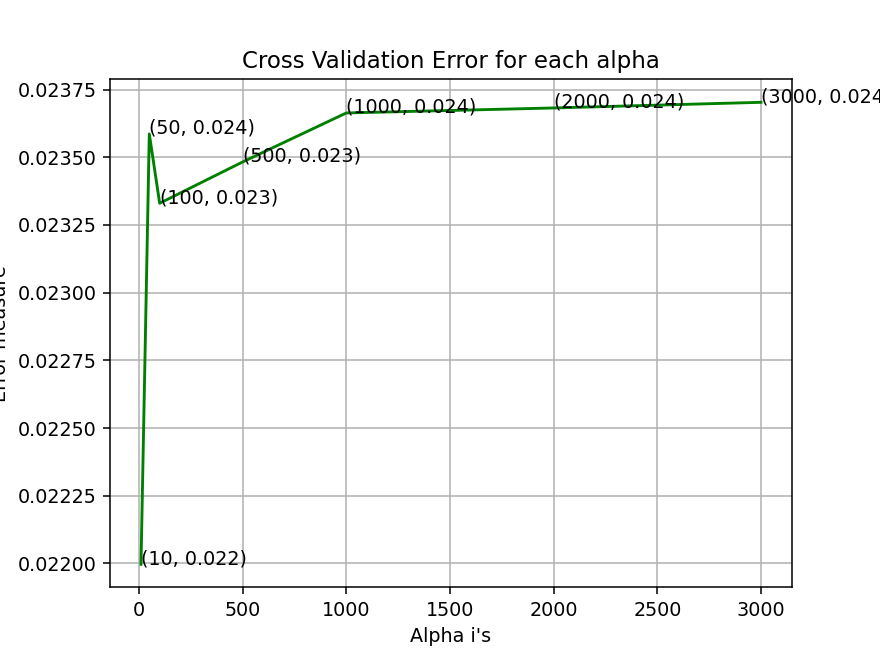

In [87]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_,y_train_)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_, y_train_)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [88]:
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_,y_train_)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_, y_train_)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=10,
                                                             n_jobs=-1,
                                                             random_state=42))

For values of best alpha =  10 The train log loss is: 0.01029007363931661
For values of best alpha =  10 The cross validation log loss is: 0.02199662709647414
For values of best alpha =  10 The test log loss is: 0.015839702829334754
Number of misclassified points  0.18399264029438822
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


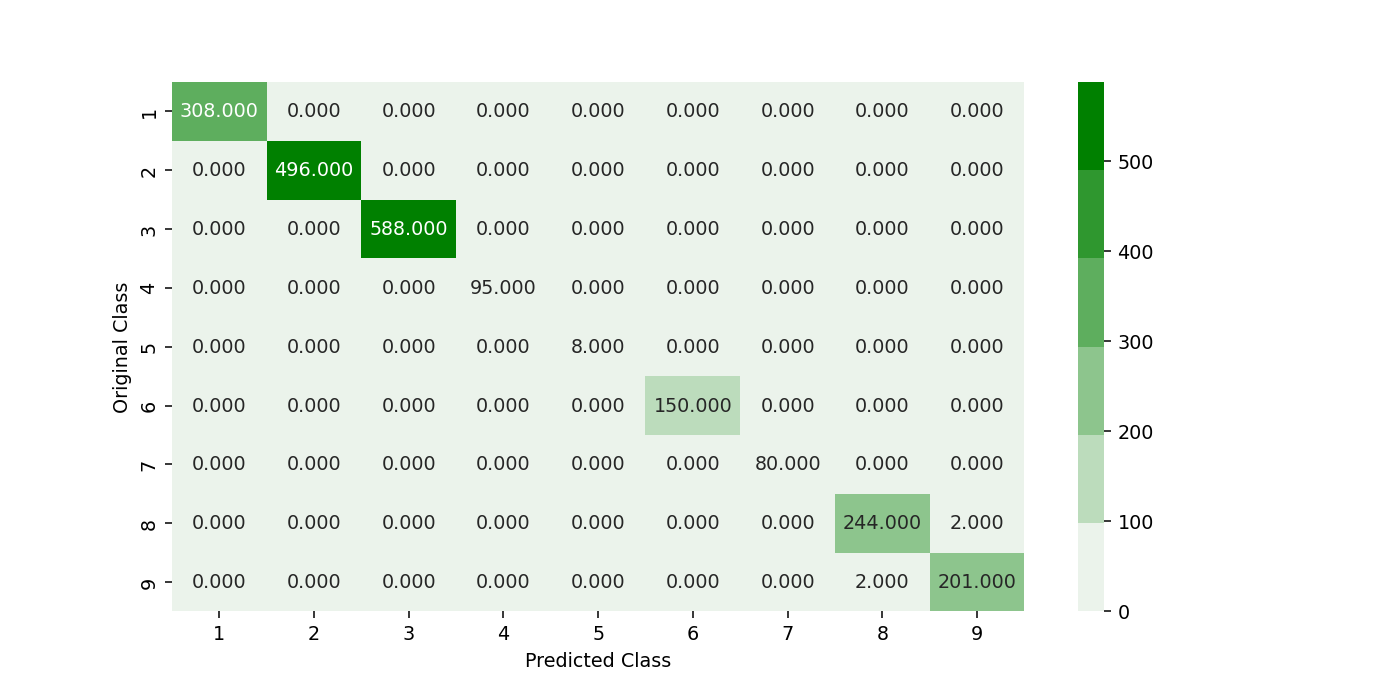

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


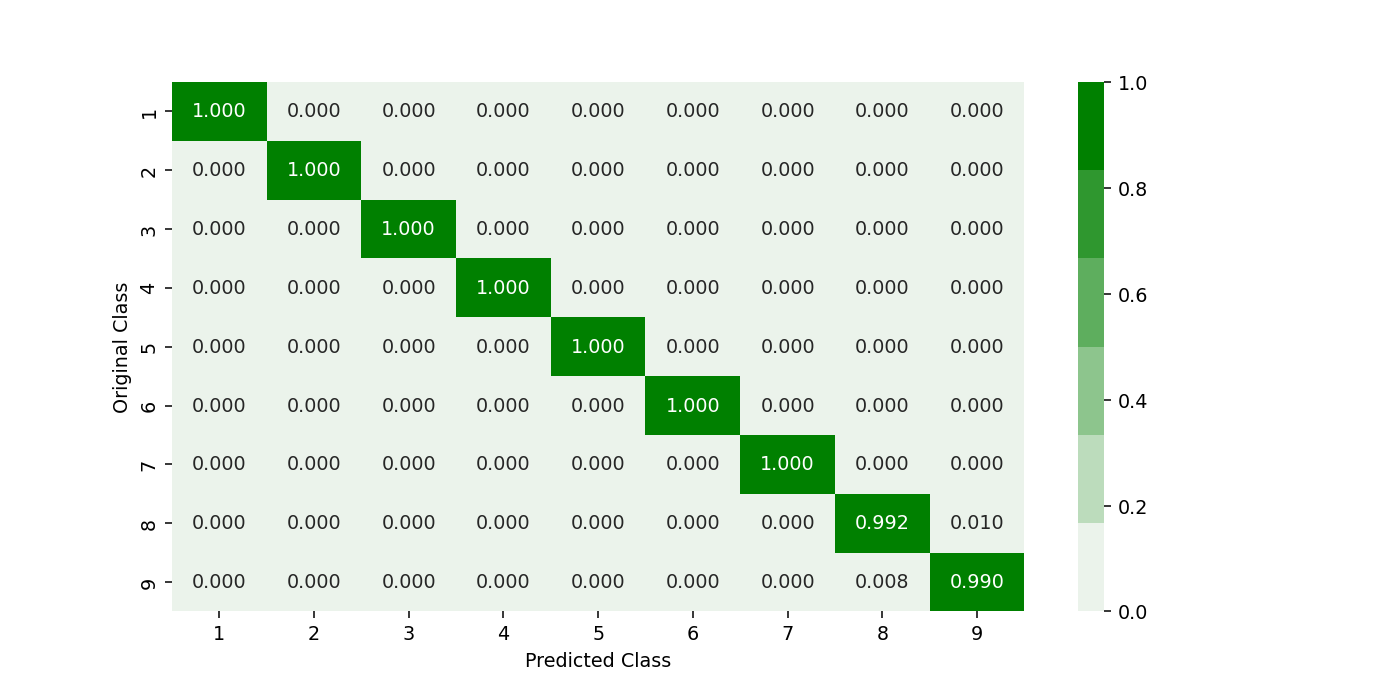

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


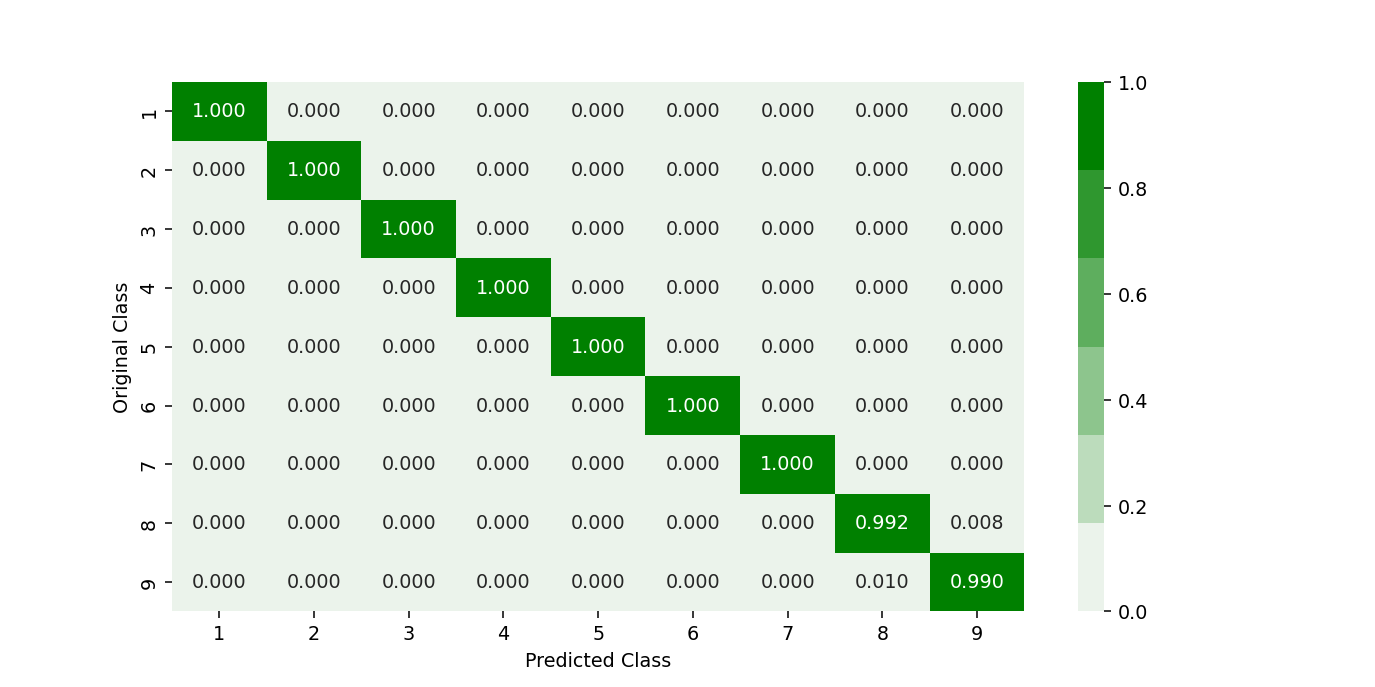

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [89]:
predict_y = sig_clf.predict_proba(X_train_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

# XGBoost

In [63]:
import xgboost as xgb

xgb.__version__

'1.7.4'

log_loss for c =  10 is 0.04388844522257457
log_loss for c =  50 is 0.039679705773500225
log_loss for c =  100 is 0.039196717107201705
log_loss for c =  500 is 0.039177483636513695
log_loss for c =  1000 is 0.03917702269363287
log_loss for c =  2000 is 0.03917703219527894
log_loss for c =  5000 is 0.039176420444273524


<IPython.core.display.Javascript object>


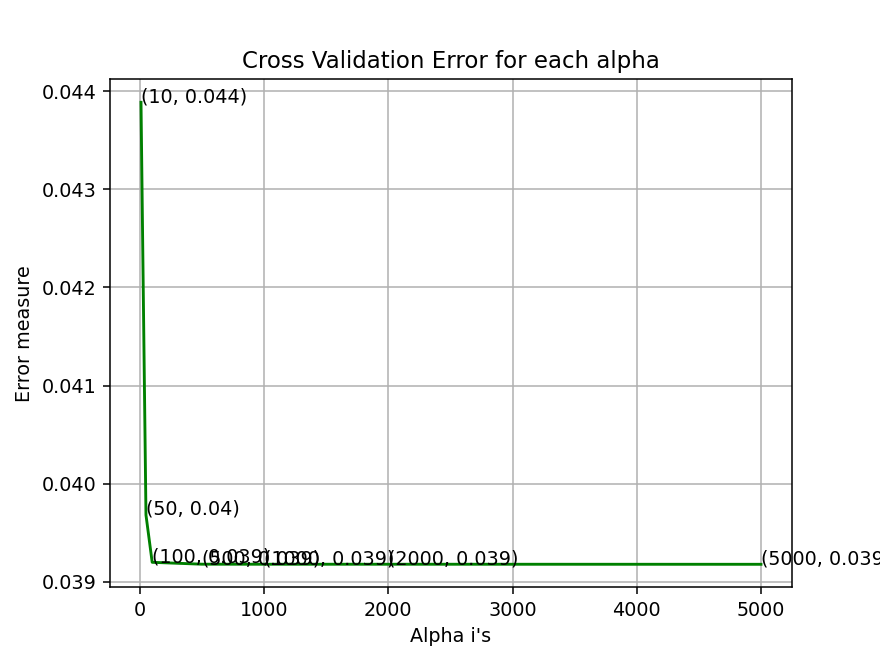

For values of best alpha =  5000 The train log loss is: 0.009816898935870498
For values of best alpha =  5000 The cross validation log loss is: 0.039176420444273524
For values of best alpha =  5000 The test log loss is: 0.01963520800384034
Number of misclassified points  0.22999080036798528
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


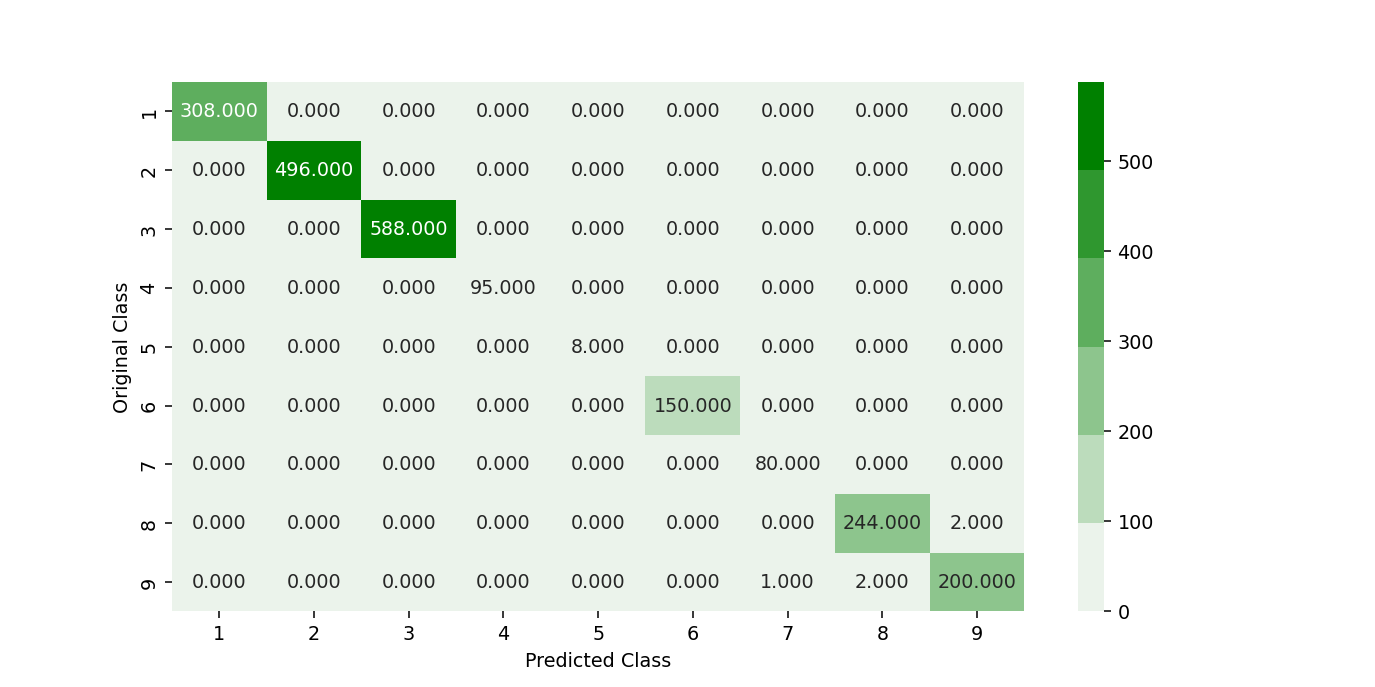

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


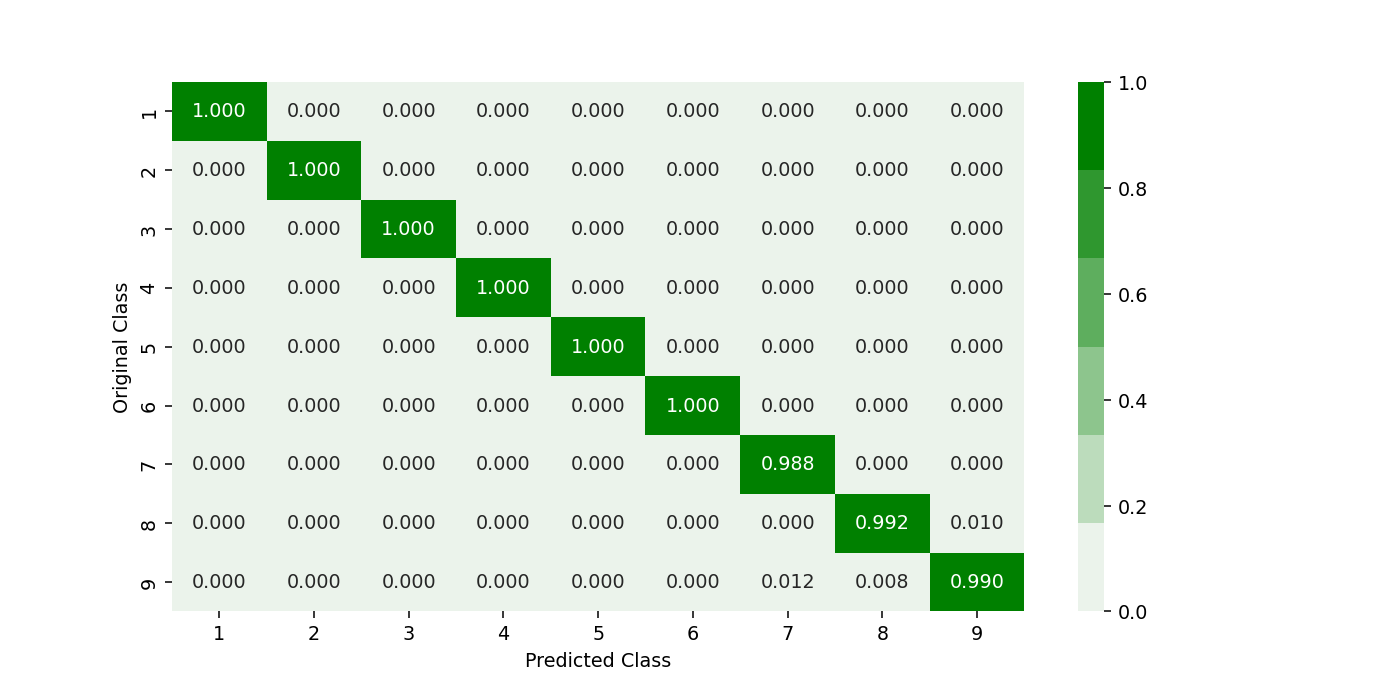

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


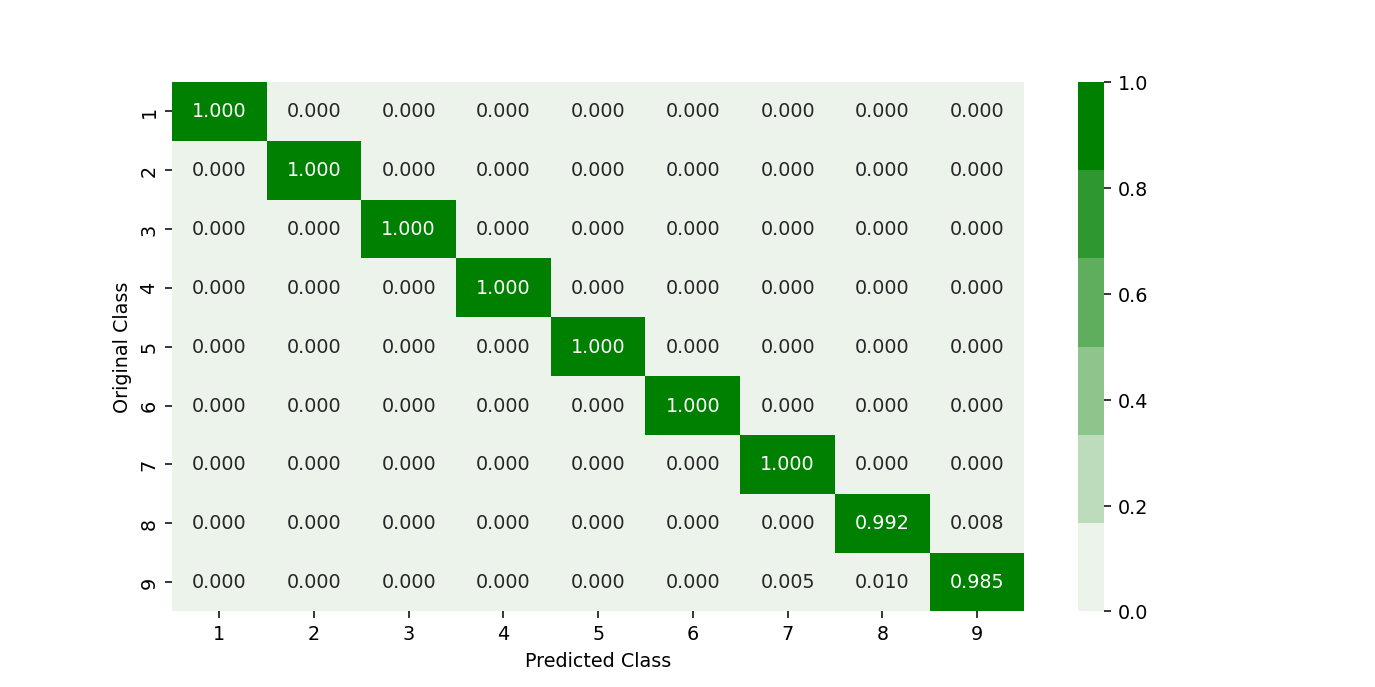

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
CPU times: total: 13h 48min 9s
Wall time: 1h 26min 54s


In [90]:
%%time
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000,5000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_,y_train_)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_, y_train_)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_,y_train_)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_, y_train_)
    
predict_y = sig_clf.predict_proba(X_train_)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [91]:
%%time
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1],
    
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train_,y_train_)

print(random_cfl1.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.3, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.3}
CPU times: total: 11min 51s
Wall time: 28min 46s


In [92]:
n_estimators = random_cfl1.best_params_['n_estimators']
max_depth = random_cfl1.best_params_['max_depth']
learning_rate = random_cfl1.best_params_['learning_rate']
colsample_bytree = random_cfl1.best_params_['colsample_bytree']
subsample = random_cfl1.best_params_['subsample']

In [93]:
%%time
x_cfl = XGBClassifier(n_estimators = n_estimators,
              max_depth = max_depth,
              learning_rate = learning_rate,
              colsample_bytree = colsample_bytree,
              subsample = subsample,
              nthread=-1)

x_cfl.fit(X_train_,y_train_,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_, y_train_)



CPU times: total: 1h 2min 53s
Wall time: 6min 29s


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=0.3,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None,
                                                    feature_types=None,
                                                    gamma=None, gpu_id=None,
                                                    grow_policy=None,
                                                    importance_type=None,
                                                    interaction_constraints=None,
                                                    learning_rate=0.2,
                                                    max_bin=None,
                                                    max_cat_threshold=None,
                                                    max_cat_to_onehot=None,
                                                    max_delta_step=None,
                                                    max_depth=5,
                                                    max_leaves=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    n_estimators=2000,
                                                    n_jobs=None, nthread=-1,
                                                    num_parallel_tree=None,
                                                    objective='multi:softprob', ...))

For values of best alpha =  5000 The train log loss is: 0.008865782697447297
For values of best alpha =  5000 The cross validation log loss is: 0.03180247156997631
For values of best alpha =  5000 The test log loss is: 0.016032462648311735
Number of misclassified points  0.13799448022079117
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


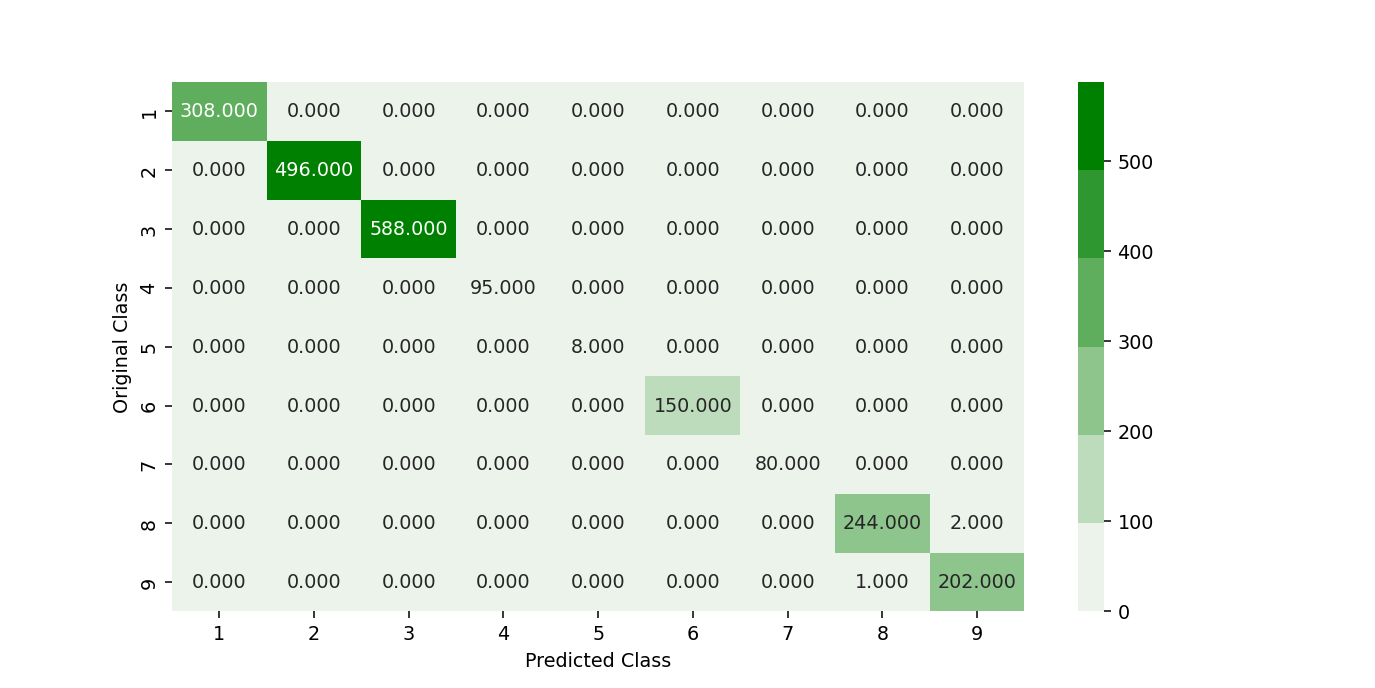

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


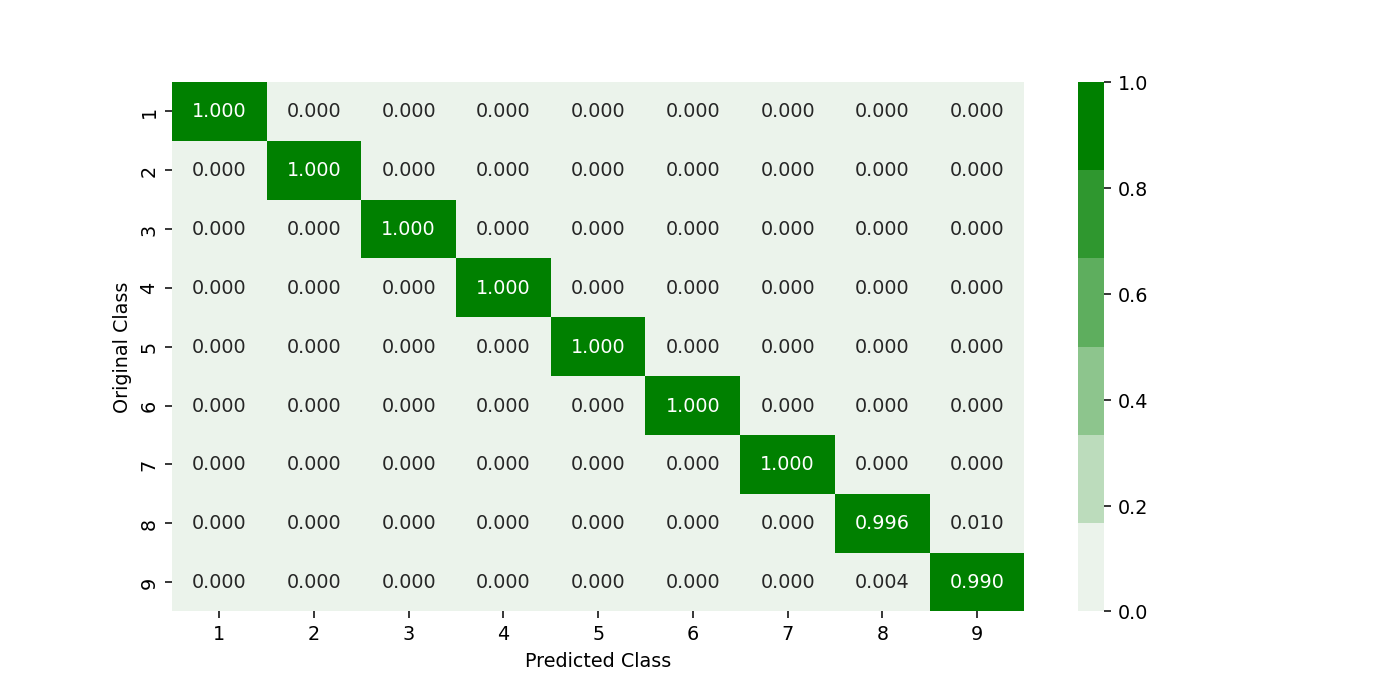

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


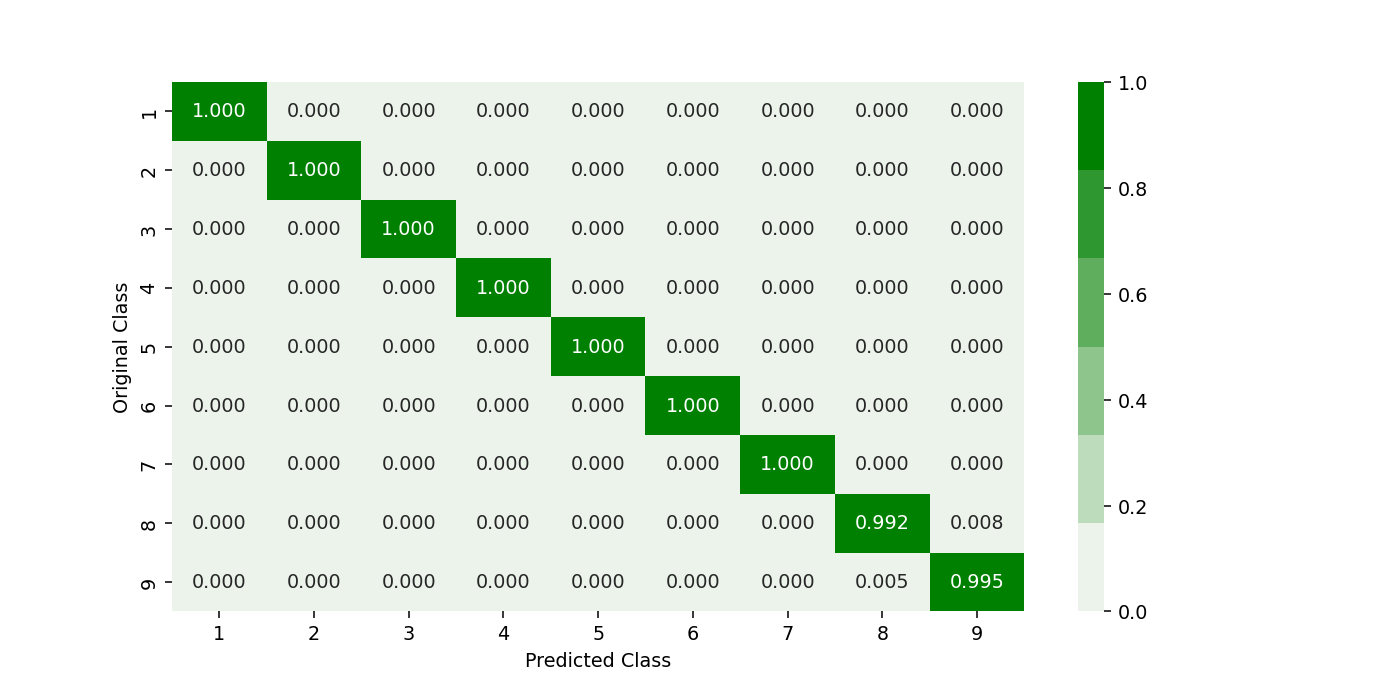

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [95]:
predict_y = sig_clf.predict_proba(X_train_)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plt.close()
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

In [97]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names  = ['Model', 'Best HyperParameter', 'Train Log Loss', 'CV Log Loss', 'Test Log Loss', 'Number of Misclassified Points']

#table.add_row(['Random Forest',])
table.add_row(['Random_Forest_Classifier', 10, 0.0102,  0.0219, 0.0158, 0.1839])
table.add_row(['Xgboost Classifier', 5000,  0.0088, 0.0318, 0.0160,  0.1379])

print(table)

+--------------------------+---------------------+----------------+-------------+---------------+--------------------------------+
|          Model           | Best HyperParameter | Train Log Loss | CV Log Loss | Test Log Loss | Number of Misclassified Points |
+--------------------------+---------------------+----------------+-------------+---------------+--------------------------------+
| Random_Forest_Classifier |          10         |     0.0102     |    0.0219   |     0.0158    |             0.1839             |
|    Xgboost Classifier    |         5000        |     0.0088     |    0.0318   |     0.016     |             0.1379             |
+--------------------------+---------------------+----------------+-------------+---------------+--------------------------------+
